## Question 3 - MNIST Classsification using PyTorch

In [0]:
import torch
import numpy as np

Load Data Sets

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


Visualize a batch of Training Set

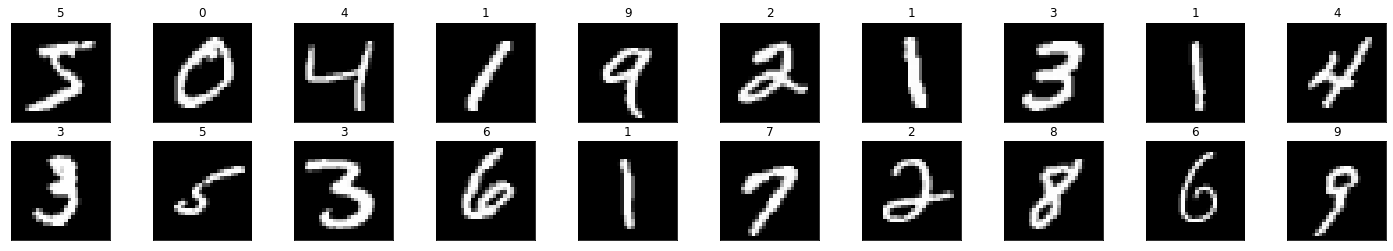

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

Define the Network Architecture

In [0]:
import torch.nn as nn
import torch.nn.functional as F

## Define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(512, 512)
        # linear layer (n_hidden -> 10)
        self.fc3 = nn.Linear(512, 10)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        return x

In [5]:
# initialize the NN
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)



Specify Loss Function and Optimizer

In [0]:
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

 Train the Network

In [7]:
n_epochs = 30  # suggest training between 20-50 epochs

model.train() # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        train_loss
        ))

Epoch: 1 	Training Loss: 0.804222
Epoch: 2 	Training Loss: 0.411707
Epoch: 3 	Training Loss: 0.370065
Epoch: 4 	Training Loss: 0.348959
Epoch: 5 	Training Loss: 0.335502
Epoch: 6 	Training Loss: 0.325918
Epoch: 7 	Training Loss: 0.318626
Epoch: 8 	Training Loss: 0.312826
Epoch: 9 	Training Loss: 0.308064
Epoch: 10 	Training Loss: 0.304058
Epoch: 11 	Training Loss: 0.300624
Epoch: 12 	Training Loss: 0.297635
Epoch: 13 	Training Loss: 0.294999
Epoch: 14 	Training Loss: 0.292651
Epoch: 15 	Training Loss: 0.290539
Epoch: 16 	Training Loss: 0.288626
Epoch: 17 	Training Loss: 0.286881
Epoch: 18 	Training Loss: 0.285279
Epoch: 19 	Training Loss: 0.283802
Epoch: 20 	Training Loss: 0.282434
Epoch: 21 	Training Loss: 0.281160
Epoch: 22 	Training Loss: 0.279970
Epoch: 23 	Training Loss: 0.278856
Epoch: 24 	Training Loss: 0.277808
Epoch: 25 	Training Loss: 0.276820
Epoch: 26 	Training Loss: 0.275887
Epoch: 27 	Training Loss: 0.275002
Epoch: 28 	Training Loss: 0.274163
Epoch: 29 	Training Loss: 0.2

Test the Trained Network¶

In [8]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for *evaluation*

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.274007

Test Accuracy of     0: 98% (962/980)
Test Accuracy of     1: 97% (1109/1135)
Test Accuracy of     2: 88% (918/1032)
Test Accuracy of     3: 90% (914/1010)
Test Accuracy of     4: 92% (909/982)
Test Accuracy of     5: 87% (781/892)
Test Accuracy of     6: 94% (910/958)
Test Accuracy of     7: 92% (946/1028)
Test Accuracy of     8: 88% (864/974)
Test Accuracy of     9: 90% (916/1009)

Test Accuracy (Overall): 92% (9229/10000)


Visualize Sample Test Results

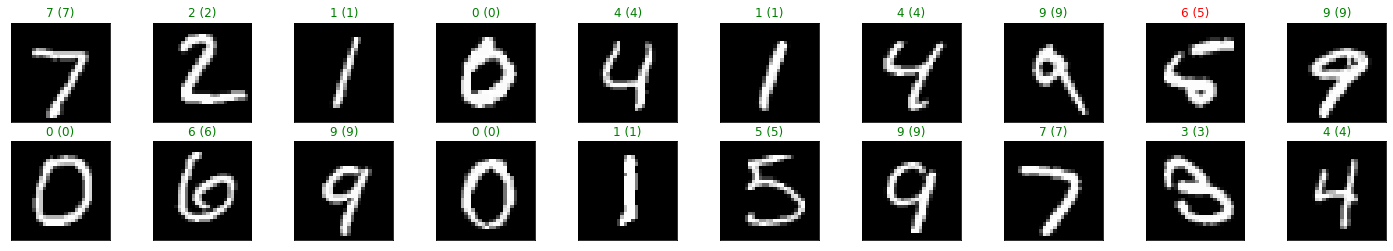

In [9]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

## MNIST Classification using CNN

In [0]:
import numpy as np # to handle matrix and data operation
import pandas as pd # to read csv and handle dataframe

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.autograd import Variable

from sklearn.model_selection import train_test_split

In [0]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [0]:
x_train = x_train.reshape(60000,784)
x_test = x_test.reshape(10000,784)

In [0]:
BATCH_SIZE = 32

In [0]:
torch_X_train = torch.from_numpy(x_train).type(torch.LongTensor)
torch_y_train = torch.from_numpy(y_train).type(torch.LongTensor) 

In [0]:
torch_X_test = torch.from_numpy(x_test).type(torch.LongTensor)
torch_y_test = torch.from_numpy(y_test).type(torch.LongTensor)

In [0]:
train = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)
test = torch.utils.data.TensorDataset(torch_X_test,torch_y_test)

In [0]:
train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = False)

In [59]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(784,250)
        self.linear2 = nn.Linear(250,100)
        self.linear3 = nn.Linear(100,10)
    
    def forward(self,X):
        X = F.relu(self.linear1(X))
        X = F.relu(self.linear2(X))
        X = self.linear3(X)
        return F.log_softmax(X, dim=1)
 
mlp = MLP()
print(mlp)

MLP(
  (linear1): Linear(in_features=784, out_features=250, bias=True)
  (linear2): Linear(in_features=250, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=10, bias=True)
)


In [0]:
def fit(model, train_loader):
    optimizer = torch.optim.Adam(model.parameters())#,lr=0.001, betas=(0.9,0.999))
    error = nn.CrossEntropyLoss()
    EPOCHS = 5
    model.train()
    for epoch in range(EPOCHS):
        correct = 0
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            var_X_batch = Variable(X_batch).float()
            var_y_batch = Variable(y_batch)
            optimizer.zero_grad()
            output = model(var_X_batch)
            loss = error(output, var_y_batch)
            loss.backward()
            optimizer.step()

            # Total correct predictions
            predicted = torch.max(output.data, 1)[1] 
            correct += (predicted == var_y_batch).sum()
            #print(correct)
            if batch_idx % 50 == 0:
                print('Epoch : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(
                    epoch, batch_idx*len(X_batch), len(train_loader.dataset), 100.*batch_idx / len(train_loader), (loss.data), float(correct*100) / float(BATCH_SIZE*(batch_idx+1))))

In [67]:
fit(mlp, train_loader)

Epoch : 0 [0/60000 (0%)]	Loss: 0.028779	 Accuracy:100.000%
Epoch : 0 [1600/60000 (3%)]	Loss: 0.135546	 Accuracy:96.875%
Epoch : 0 [3200/60000 (5%)]	Loss: 0.161492	 Accuracy:97.061%
Epoch : 0 [4800/60000 (8%)]	Loss: 0.029837	 Accuracy:97.144%
Epoch : 0 [6400/60000 (11%)]	Loss: 0.251311	 Accuracy:97.233%
Epoch : 0 [8000/60000 (13%)]	Loss: 0.288707	 Accuracy:96.987%
Epoch : 0 [9600/60000 (16%)]	Loss: 0.001341	 Accuracy:96.564%
Epoch : 0 [11200/60000 (19%)]	Loss: 0.147621	 Accuracy:96.270%
Epoch : 0 [12800/60000 (21%)]	Loss: 0.162637	 Accuracy:96.213%
Epoch : 0 [14400/60000 (24%)]	Loss: 0.040754	 Accuracy:96.182%
Epoch : 0 [16000/60000 (27%)]	Loss: 0.053642	 Accuracy:96.214%
Epoch : 0 [17600/60000 (29%)]	Loss: 0.021809	 Accuracy:96.257%
Epoch : 0 [19200/60000 (32%)]	Loss: 0.007951	 Accuracy:96.339%
Epoch : 0 [20800/60000 (35%)]	Loss: 0.117186	 Accuracy:96.376%
Epoch : 0 [22400/60000 (37%)]	Loss: 0.001032	 Accuracy:96.438%
Epoch : 0 [24000/60000 (40%)]	Loss: 0.240103	 Accuracy:96.451%
Epoch

In [68]:
def evaluate(model):
#model = mlp
    correct = 0 
    for test_imgs, test_labels in test_loader:
        #print(test_imgs.shape)
        test_imgs = Variable(test_imgs).float()
        output = model(test_imgs)
        predicted = torch.max(output,1)[1]
        correct += (predicted == test_labels).sum()
    print("Test accuracy:{:.3f}% ".format( float(correct) / (len(test_loader)*BATCH_SIZE)))
evaluate(mlp)

Test accuracy:0.971% 


##Since a CNN needs a image shape as input let's reshape our flatten images to real image

In [69]:
torch_X_train = torch_X_train.view(-1, 1,28,28).float()
torch_X_test = torch_X_test.view(-1,1,28,28).float()
print(torch_X_train.shape)
print(torch_X_test.shape)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)
test = torch.utils.data.TensorDataset(torch_X_test,torch_y_test)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = False)MB 

torch.Size([60000, 1, 28, 28])
torch.Size([10000, 1, 28, 28])


In [70]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32,64, kernel_size=5)
        self.fc1 = nn.Linear(3*3*64, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        #x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv3(x),2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = x.view(-1,3*3*64 )
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
 
cnn = CNN()
print(cnn)

it = iter(train_loader)
X_batch, y_batch = next(it)
print(cnn.forward(X_batch).shape)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)
torch.Size([32, 10])


In [71]:


fit(cnn,train_loader)



Epoch : 0 [0/60000 (0%)]	Loss: 24.703955	 Accuracy:6.250%
Epoch : 0 [1600/60000 (3%)]	Loss: 1.980315	 Accuracy:17.279%
Epoch : 0 [3200/60000 (5%)]	Loss: 1.460487	 Accuracy:29.115%
Epoch : 0 [4800/60000 (8%)]	Loss: 0.748759	 Accuracy:38.949%
Epoch : 0 [6400/60000 (11%)]	Loss: 1.238455	 Accuracy:45.553%
Epoch : 0 [8000/60000 (13%)]	Loss: 0.865389	 Accuracy:50.461%
Epoch : 0 [9600/60000 (16%)]	Loss: 0.764462	 Accuracy:54.485%
Epoch : 0 [11200/60000 (19%)]	Loss: 0.602340	 Accuracy:58.191%
Epoch : 0 [12800/60000 (21%)]	Loss: 0.548422	 Accuracy:60.793%
Epoch : 0 [14400/60000 (24%)]	Loss: 0.491586	 Accuracy:63.089%
Epoch : 0 [16000/60000 (27%)]	Loss: 0.702923	 Accuracy:64.814%
Epoch : 0 [17600/60000 (29%)]	Loss: 0.591373	 Accuracy:66.640%
Epoch : 0 [19200/60000 (32%)]	Loss: 0.427941	 Accuracy:68.225%
Epoch : 0 [20800/60000 (35%)]	Loss: 0.508253	 Accuracy:69.772%
Epoch : 0 [22400/60000 (37%)]	Loss: 0.220711	 Accuracy:71.122%
Epoch : 0 [24000/60000 (40%)]	Loss: 0.182511	 Accuracy:72.121%
Epoch 

## SVM Classifer for MNIST DATA SET

In [0]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [0]:
x_train = x_train.reshape(60000,784)
x_test = x_test.reshape(10000,784)

In [0]:
## Applying HOG feature extraction

In [0]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from skimage.feature import hog
from sklearn import preprocessing
from collections import Counter

In [38]:
list_hog_train = []
for feature in x_train:
    fd = hog(feature.reshape((28,28)), orientations=10, pixels_per_cell=(7,7),cells_per_block=(1,1),visualize=False )
    list_hog_train.append(fd)
hog_features = np.array(list_hog_train, 'float64')
preProcess = preprocessing.MaxAbsScaler().fit(hog_features)
hog_features_transformed_train = preProcess.transform(hog_features)
print(hog_features_transformed_train.shape)

(60000, 160)


In [0]:
## Extracting hog feature for test data

In [41]:
list_hog_test = []
for feature in x_test:
    fd = hog(feature.reshape((28,28)), orientations=10, pixels_per_cell=(7,7),cells_per_block=(1,1),visualize=False )
    list_hog_test.append(fd)
hog_features_test = np.array(list_hog_test, 'float64')
preProcess = preprocessing.MaxAbsScaler().fit(hog_features_test)
hog_features_transformed_test = preProcess.transform(hog_features_test)
print(hog_features_transformed_test.shape)

(10000, 160)


In [0]:
model = SVC()
model.fit(hog_features_transformed_train,y_train)
y_pred = model.predict(hog_features_transformed_test)

Fitting the model with best parameters

In [43]:
print(accuracy_score(y_test, y_pred))

0.9713
